# MARCOS JOSÉ AZEVEDO

# Esse script faz uma predição usando apenas as 3 features escolhidas para o teste: useableAreas, bathrooms e suítes.

# Importando as Bibliotecas

In [1]:
import json
import pandas as pd
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score


import warnings
warnings.filterwarnings('ignore')


# Importando o arquivo treino

In [2]:
url_treino = "https://s3.amazonaws.com/grupozap-data-challenge/data/source-4-ds-train.json.zip"

In [3]:
json = pd.read_json(url_treino, encoding="utf8", lines=True)

In [4]:
json.head(3)

,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,address,suites,publicationType,bathrooms,totalAreas,bedrooms,pricingInfos
0,388.0,"04 dorms sendo 01 suíte e closet, sala de esta...",PRÓXIMO A AVENIDA PRESIDENTE TANCREDO NEVES,2017-02-07T13:21:40Z,f4603b2b52,TWO_STORY_HOUSE,ACTIVE,787c7bd19d,6.0,2018-12-06T19:27:12.623Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,"{'country': 'BR', 'zipCode': '04290030', 'city...",1.0,STANDARD,3.0,388.0,4.0,"{'price': 700000, 'businessType': 'SALE'}"
1,129.0,"03 dorms sendo 01 suíte, sala, sala de jantar,...",PRÓXIMO A FACULDADE UNIP CAMPUS ANCHIETA,2016-03-21T18:35:17Z,f4603b2b52,HOME,ACTIVE,4d68c0cdbe,2.0,2018-12-12T13:17:23.547Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,"{'country': 'BR', 'zipCode': '04187320', 'city...",1.0,STANDARD,2.0,129.0,3.0,"{'price': 336000, 'businessType': 'SALE'}"
2,396.0,"Andar com 395,70m² de área útil, 04 wcs, 05 va...",Excelente Conjunto Comercial na Av. Paulista,2018-12-18T23:47:03.425Z,501f6d5e94,COMMERCIAL_PROPERTY,ACTIVE,e7e0b554ac,5.0,NaN,False,[http://static.nidoimovel.com.br/d3d9446802a44...,"{'country': '', 'zipCode': '01311000', 'city':...",0.0,STANDARD,4.0,NaN,0.0,"{'period': 'MONTHLY', 'yearlyIptu': 4040, 'pri..."


# Normalizando as colunas

In [5]:
df_treino = (pd.DataFrame(json['pricingInfos']
                     .values.tolist())
                     .add_prefix('pricingInfos_')
                     .join(json.drop('pricingInfos', 1)))

In [6]:
df_treino = (pd.DataFrame(df_treino['address']
                     .values.tolist())
                     .add_prefix('address_')
                     .join(df_treino.drop('address', 1)))

In [7]:
df_treino.head(3)

,address_country,address_zipCode,address_city,address_streetNumber,address_zone,address_geoLocation,address_street,address_locationId,address_district,address_unitNumber,...,id,parkingSpaces,updatedAt,owner,images,suites,publicationType,bathrooms,totalAreas,bedrooms
0,BR,04290030,São Paulo,53,Zona Sul,"{'precision': 'ROOFTOP', 'location': {'lon': -...",Rua Juvenal Galeno,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,,,...,787c7bd19d,6.0,2018-12-06T19:27:12.623Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,1.0,STANDARD,3.0,388.0,4.0
1,BR,04187320,São Paulo,16,Zona Sul,"{'precision': 'RANGE_INTERPOLATED', 'location'...",Rua Juruaba,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,,,...,4d68c0cdbe,2.0,2018-12-12T13:17:23.547Z,False,[https://s3-sa-east-1.amazonaws.com/vr.images....,1.0,STANDARD,2.0,129.0,3.0
2,,01311000,São Paulo,402,,"{'precision': 'ROOFTOP', 'location': {'lon': -...",Avenida Paulista,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,,,...,e7e0b554ac,5.0,NaN,False,[http://static.nidoimovel.com.br/d3d9446802a44...,0.0,STANDARD,4.0,NaN,0.0


In [8]:
s = df_treino['address_geoLocation'].apply(pd.Series).add_prefix("geoLocation_")

In [9]:
s.head(3)

,geoLocation_0,geoLocation_location,geoLocation_precision
0,NaN,"{'lon': -46.614222, 'lat': -23.612923}",ROOFTOP
1,NaN,"{'lon': -46.593475, 'lat': -23.643962}",RANGE_INTERPOLATED
2,NaN,"{'lon': -46.647452, 'lat': -23.568559}",ROOFTOP


In [10]:
df_treino = pd.concat([df_treino.drop(["address_geoLocation"], axis=1), s], axis=1)

In [11]:
geolocation = df_treino['geoLocation_location'].apply(pd.Series).add_prefix("geolocation_")

In [12]:
geolocation.head(3)

,geolocation_0,geolocation_lat,geolocation_lon
0,NaN,-23.612923,-46.614222
1,NaN,-23.643962,-46.593475
2,NaN,-23.568559,-46.647452


In [13]:
df_treino = pd.concat([df_treino.drop(["geoLocation_location"], axis=1), geolocation], axis=1)

In [14]:
colunas_apagar = ['geolocation_0', 'geoLocation_0']

In [15]:
df_treino = df_treino.drop(colunas_apagar, 1)

# Criando o dataframe exclusivo com imóveis à Venda

In [16]:
df_treino['pricingInfos_businessType'].value_counts(dropna=False).nlargest()

SALE      105332
RENTAL     28632
Name: pricingInfos_businessType, dtype: int64

In [17]:
df_treino = df_treino[(df_treino['pricingInfos_businessType']=='SALE')]

# Criando dataframe com as 3 variáveis escolhidas para o teste

In [18]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105332 entries, 0 to 133962
Data columns (total 37 columns):
address_country                  105332 non-null object
address_zipCode                  105332 non-null object
address_city                     105332 non-null object
address_streetNumber             105332 non-null object
address_zone                     105332 non-null object
address_street                   105332 non-null object
address_locationId               105332 non-null object
address_district                 105332 non-null object
address_unitNumber               105332 non-null object
address_state                    105332 non-null object
address_neighborhood             105332 non-null object
pricingInfos_price               105332 non-null int64
pricingInfos_businessType        105332 non-null object
pricingInfos_period              419 non-null object
pricingInfos_yearlyIptu          87587 non-null float64
pricingInfos_rentalTotalPrice    95 non-null float64


In [30]:
df_3var = df_treino[['usableAreas', 
                     'bathrooms', 
                     'suites', 
                     'pricingInfos_price']]

### Tratando as variáveis

In [31]:
df_3var.isnull().sum()

usableAreas            686
bathrooms              668
suites                9705
pricingInfos_price       0
dtype: int64

In [32]:
df_3var['suites'].fillna(df_3var['suites'].mean(),inplace=True)
df_3var['bathrooms'].fillna(df_3var['bathrooms'].mean(),inplace=True)
df_3var['usableAreas'].fillna(df_3var['usableAreas'].mean(),inplace=True)

In [33]:
df_3var['log_usableAreas'] = np.log1p(df_3var['usableAreas'])

# Criando o Modelo

In [34]:
X = df_3var.drop(['pricingInfos_price'], axis=1)
y = np.log1p(df_3var['pricingInfos_price'])

In [35]:
X.shape

(105332, 4)

In [37]:
y.shape

(105332,)

# Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escolhendo o melhor modelo

SCORE TREINO:  0.50503609112634
SCORE TESTE:  0.5170226294897327
Model LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
****Results****
R2: 0.517

MSE: 0.3299



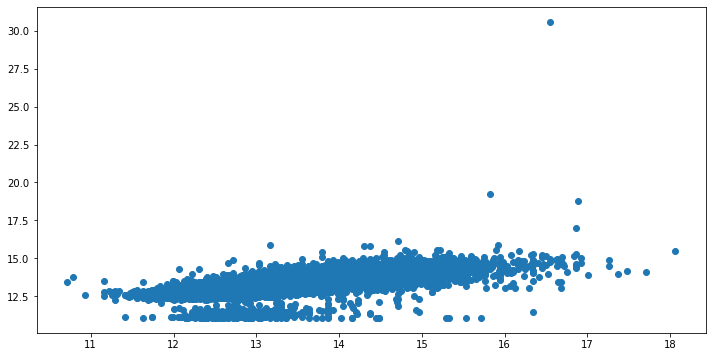

SCORE TREINO:  0.7692817554513801
SCORE TESTE:  0.6909995160278257
Model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
****Results****
R2: 0.691

MSE: 0.211



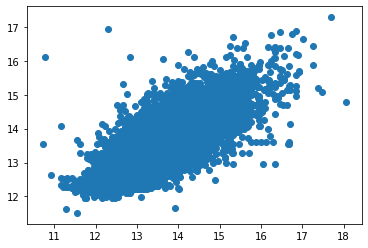

SCORE TREINO:  0.7033298329601388
SCORE TESTE:  0.7014565551817447
Model GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
****Results****
R2: 0.7015

MSE: 0.2039



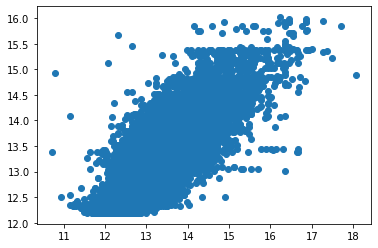

In [39]:
linear_model = LinearRegression()
rforest_model = RandomForestRegressor()
grad_model = GradientBoostingRegressor()

models = [linear_model, rforest_model, grad_model]
plt.figure(figsize=(12,6))

for model in models:
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)

    #Metrics
    r2 = r2_score(y_test, yhat)
    mse = mean_squared_error(y_test, yhat)
    
    print("SCORE TREINO: ", model.score(X_train, y_train))
    print("SCORE TESTE: ", model.score(X_test, y_test))
        
    print("="*30)
    print(f'Model {str(model)}')
    print('****Results****')
    print(f'R2: {round(r2, 4)}\n')  #quanto mais perto de 1 melhor
    print(f'MSE: {round(mse, 4)}\n')   #quanto mais perto de zero melhor
    plt.scatter(y_test, yhat)    
    plt.show()

# Treinando o melhor modelo

In [40]:
grad_model.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [41]:
print("SCORE TREINO: ", grad_model.score(X_train, y_train))
print("SCORE TESTE: ",grad_model.score(X_test, y_test))

SCORE TREINO:  0.7033205084174647
SCORE TESTE:  0.706231036243973


# Importando o arquivo teste

In [42]:
url_teste = "https://s3.amazonaws.com/grupozap-data-challenge/data/source-4-ds-test.json.zip"

In [43]:
json_teste = pd.read_json(url_teste, encoding="utf8", lines=True)

# Normalizando as colunas

In [44]:
df_teste = (pd.DataFrame(json_teste['pricingInfos']
                     .values.tolist())
                     .add_prefix('pricingInfos_')
                     .join(json_teste.drop('pricingInfos', 1)))

df_teste = (pd.DataFrame(df_teste['address']
                     .values.tolist())
                     .add_prefix('address_')
                     .join(df_teste.drop('address', 1)))

s = df_teste['address_geoLocation'].apply(pd.Series).add_prefix("geoLocation_")
df_teste = pd.concat([df_teste.drop(["address_geoLocation"], axis=1), s], axis=1)
geolocation = df_teste['geoLocation_location'].apply(pd.Series).add_prefix("geolocation_")
df_teste = pd.concat([df_teste.drop(["geoLocation_location"], axis=1), geolocation], axis=1)
colunas_apagar = ['geolocation_0', 'geoLocation_0']
df_teste = df_teste.drop(colunas_apagar, 1)

# Criando o dataframe teste para imóveis à Venda

In [51]:
df_teste = df_teste[(df_teste['pricingInfos_businessType']=='SALE')]

In [52]:
X_Real = df_teste[list(X)]

In [53]:
X_Real['suites'].fillna(X_Real['suites'].mean(),inplace=True)
X_Real['bathrooms'].fillna(X_Real['bathrooms'].mean(),inplace=True)
X_Real['usableAreas'].fillna(X_Real['usableAreas'].mean(),inplace=True)

In [54]:
X_Real['log_usableAreas'] = np.log1p(X_Real['usableAreas'])

In [55]:
X_Real.head()

,usableAreas,bathrooms,suites,log_usableAreas
0,47.0,1.0,0.0,3.871201
1,55.0,0.0,0.0,4.025352
2,92.0,3.0,1.0,4.532599
3,145.0,4.0,3.0,4.983607
4,76.0,2.0,1.0,4.343805


# Aplicando o Predict

In [56]:
y_pred = grad_model.predict(X_Real)

In [57]:
df_teste['price'] = np.exp(y_pred)

### Exportando o arquivo csv com o resultado

In [59]:
df_resultado = pd.DataFrame(df_teste, columns=['id','price'])

In [60]:
df_resultado.to_csv(r'./resultado_3_variaveis.csv', index=False)

# Histograma

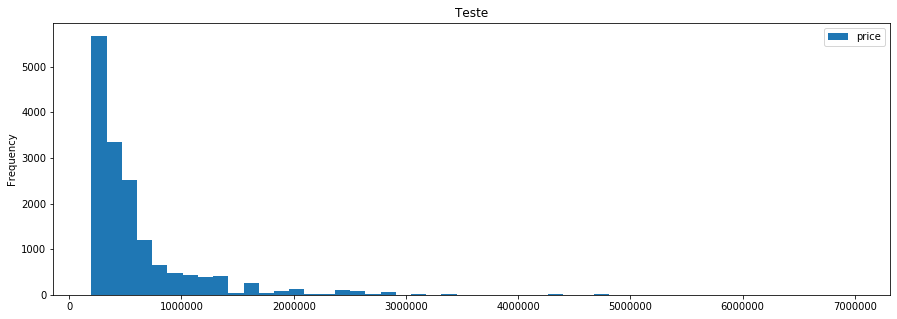

In [61]:
df_teste[['price']].plot(
    kind='hist',    
    figsize=(15, 5),
    bins=50,
    title='Teste'
);